# Demo for GmshMesh

In [11]:
%load_ext autoreload
%autoreload 2

from FEMesh import readmsh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple mesh

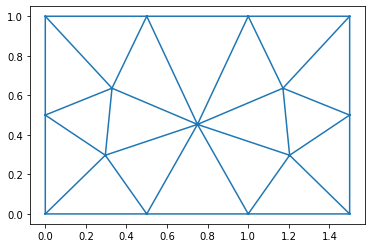

In [12]:
m = readmsh('gmsh/rectangle-0.msh')
m.plot()

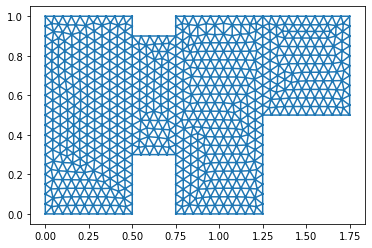

In [13]:
m = readmsh('gmsh/complex.msh')
m.plot()